# **Importar librerías externas**

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
#!pip install datasets

In [3]:
!pip install keras-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.8 MB/s eta 0:00:00


In [4]:
import keras_core

Using TensorFlow backend


# **Preparación del conjunto de datos de entrenamiento**

# Importando el conjunto de datos

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
#!mkdir /content/drive/MyDrive/project_sample

In [7]:
#!curl -L -o /content/drive/MyDrive/project_sample/plantvillage-potato-disease-dataset.zip\
#  https://www.kaggle.com/api/v1/datasets/download/aarishasifkhan/plantvillage-potato-disease-dataset

In [8]:
#!unzip /content/drive/MyDrive/project_sample/plantvillage-potato-disease-dataset.zip -d /content/drive/MyDrive/project_sample/

# Limpieza de los datos

In [9]:
DATASET_PATH = "/content/drive/MyDrive/project_sample/PlantVillage"

In [10]:
import tensorflow as tf
import os

def filter_images():
  deleted_imgs = 0
  for folder_name in ("Potato___Early_blight", "Potato___healthy","Potato___Late_blight"):
    folder_path = os.path.join(DATASET_PATH, folder_name)
    for image in os.listdir(folder_path):
      image_path = os.path.join(folder_path, image)
      try:
        fobj = open(image_path, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)

        # Comprueba si la imagen está vacía o tiene tamaño cero
        img = tf.io.read_file(image_path)
        try:
          img_tensor = tf.image.decode_jpeg(img)
        except tf.errors.InvalidArgumentError:
          is_jfif = False  # Tratar los errores de decodificación como no JFIF

        if img_tensor.shape[0] == 0 or img_tensor.shape[1] == 0:
          is_jfif = False
          print(f"Found invalid image with zero dimension: {image_path}")

      finally:
        fobj.close()

      if not is_jfif:
        deleted_imgs += 1
        os.remove(image_path)
        print(f"Removed invalid image: {image_path}")

  print(f"Deleted {deleted_imgs} images")

In [11]:
filter_images()

Deleted 0 images


# Creación de un Dataset con Keras

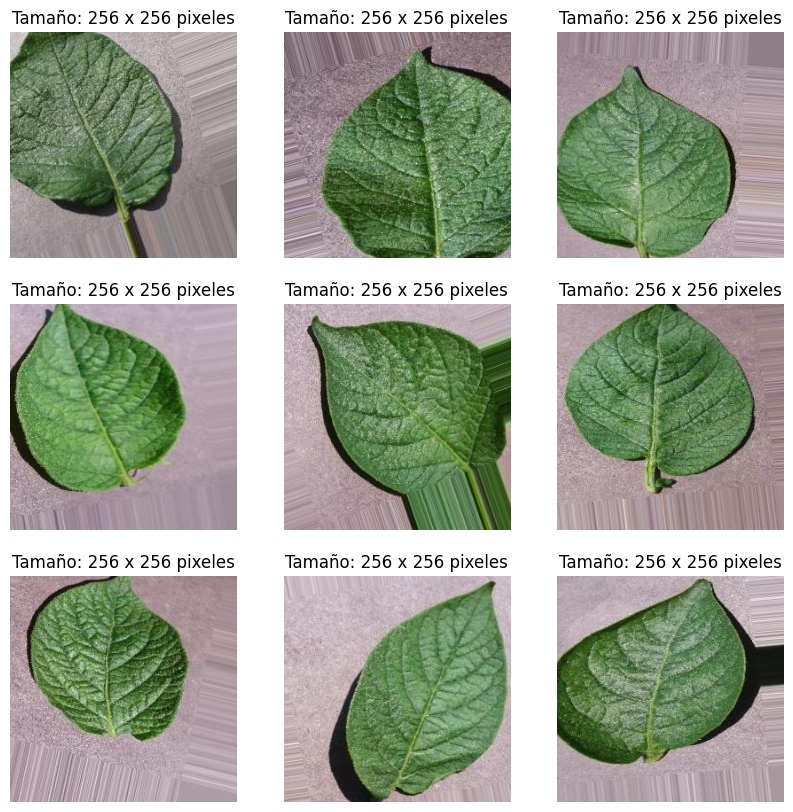

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

plt.figure(figsize=(10, 10))

folder_path = os.path.join(DATASET_PATH, "Potato___healthy")
for i, image in enumerate(os.listdir(folder_path)[:9]):
  img_path = os.path.join(folder_path, image)
  img = mpimg.imread(img_path)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} pixeles")
  plt.axis("off")
plt.show()

In [13]:
image_size = (256,256)
batch_size = 32

In [14]:
train_ds = keras_core.utils.image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    validation_split=0.4,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 3392 files belonging to 3 classes.
Using 2036 files for training.


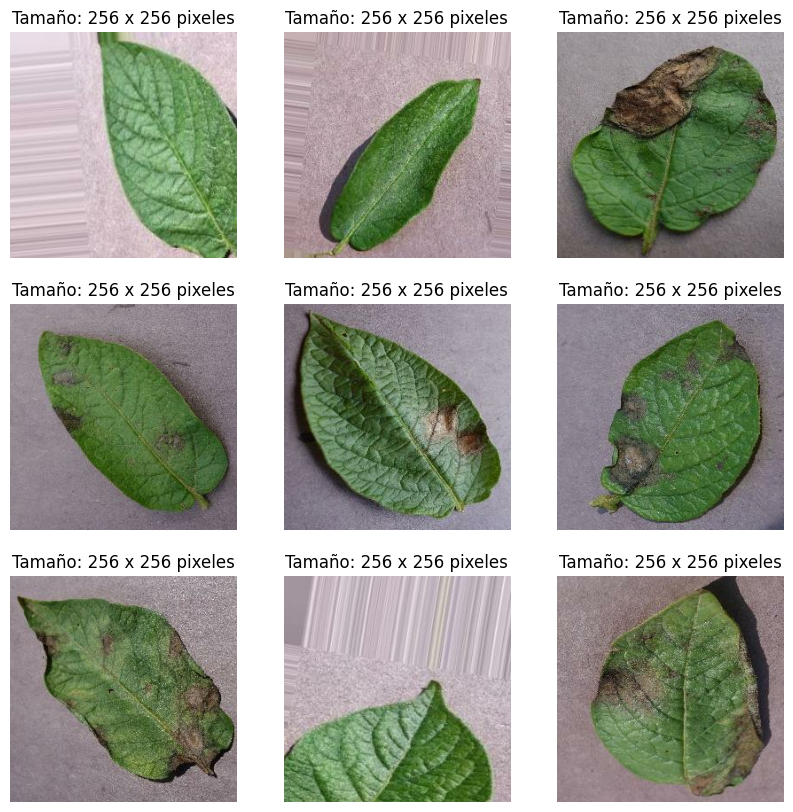

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} pixeles")
    plt.axis("off")
plt.show()

# Separación de la etiqueta (label)

In [16]:
len(train_ds)

64

In [17]:
batch1 = list(train_ds.take(1))
batch1

[(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
  array([[[[165., 161., 175.],
           [166., 162., 176.],
           [167., 163., 177.],
           ...,
           [138., 132., 146.],
           [138., 132., 146.],
           [135., 129., 143.]],
  
          [[165., 161., 175.],
           [165., 161., 175.],
           [166., 162., 176.],
           ...,
           [142., 136., 150.],
           [143., 137., 151.],
           [141., 135., 149.]],
  
          [[169., 165., 179.],
           [168., 164., 178.],
           [167., 163., 177.],
           ...,
           [137., 131., 145.],
           [137., 131., 145.],
           [134., 128., 142.]],
  
          ...,
  
          [[159., 155., 170.],
           [160., 156., 171.],
           [160., 156., 171.],
           ...,
           [114., 106., 121.],
           [110., 102., 117.],
           [106.,  98., 113.]],
  
          [[157., 153., 168.],
           [159., 155., 170.],
           [160., 156., 171.],
    

In [18]:
print(f"Número de imágenes en el primer batch: {len(batch1[0][0])}")
print(f"Etiqueta de batch: {batch1[0][1]}")

Número de imágenes en el primer batch: 32
Etiqueta de batch: [1 0 2 0 1 2 0 0 1 0 2 2 0 1 0 0 1 1 2 1 0 1 1 1 2 1 1 1 1 2 2 0]


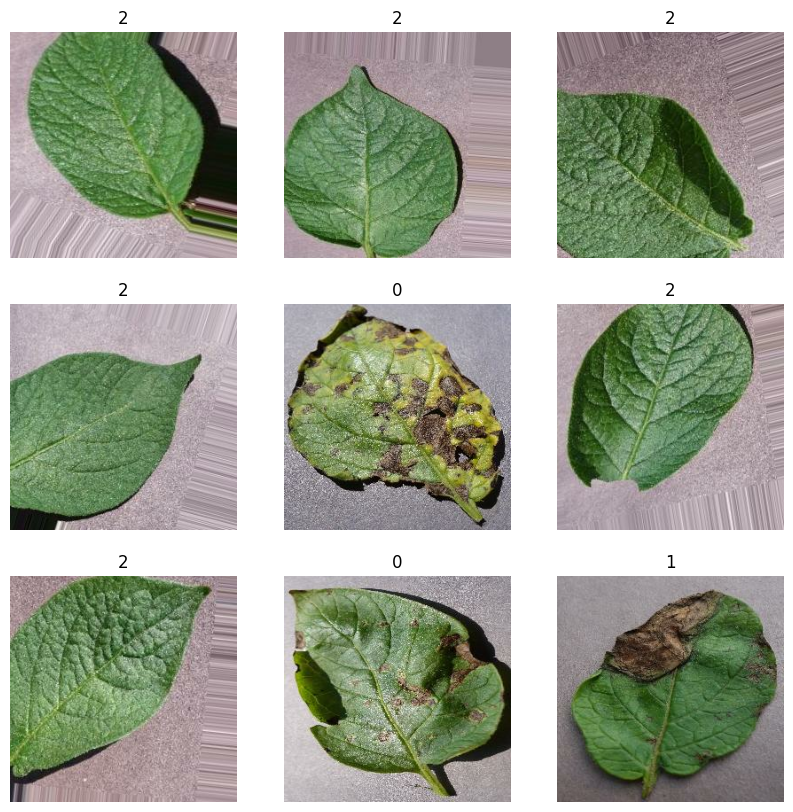

In [19]:
plt.figure(figsize=(10, 10))
for image, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")
plt.show()

#Etiquetas
#0: "Potato___Late_blight"
#1: "Potato___Early_blight"
#2: "Potato___healthy"

# División del conjunto de datos

In [20]:
image_size = (256,256)
batch_size = 32

temp_val_ds = keras_core.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.50,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 3392 files belonging to 3 classes.
Using 1696 files for validation.


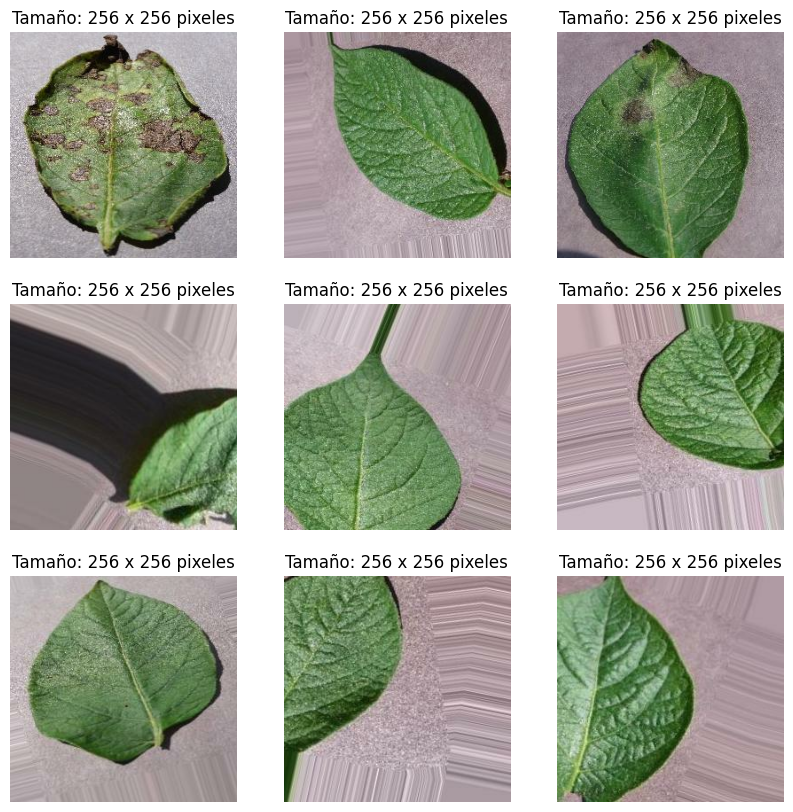

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in temp_val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} pixeles")
    plt.axis("off")
plt.show()

In [22]:
len(temp_val_ds)

53

In [23]:
val_size = int(len(temp_val_ds) * 0.5)
val_ds = temp_val_ds.take(val_size)
test_ds = temp_val_ds.skip(val_size)

In [24]:
len(val_ds)

26

In [25]:
len(test_ds)

27

In [26]:
val_ds_sk = list(temp_val_ds)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
val_ds_sk, test_ds_sk = train_test_split(val_ds_sk, test_size=0.5, random_state=42)

In [29]:
len(val_ds_sk)

26

In [30]:
len(test_ds_sk)

27

# **Definición de la arquitectura de la Red Neuronal Artificial**

# Definición de capas para conjunto de neuronas

In [31]:
from keras_core import layers  # Importa las capas necesarias para construir la red neuronal
from keras_core.optimizers import Adam

input_shape = (256, 256, 3)  # Define la forma de entrada de las imágenes (256x256 píxeles, 3 canales de color RGB)

fcnn_model = keras_core.Sequential()  # Crea un modelo secuencial, donde las capas se apilan linealmente

# Agrega la capa de entrada, especificando la forma de los datos de entrada
fcnn_model.add(layers.Input(shape=input_shape))
fcnn_model.add(layers.Rescaling(1.0/255))  # Escala los valores de píxeles al rango [0, 1]

fcnn_model.add(layers.Flatten())  # Convierte la imagen en un vector unidimensional

# Agrega capas densas (completamente conectadas) con la función de activación ReLU
fcnn_model.add(layers.Dense(384, activation="relu"))  # 384 neuronas en esta capa
fcnn_model.add(layers.Dense(256, activation="relu"))  # 256 neuronas en esta capa
fcnn_model.add(layers.Dense(128, activation="relu"))  # 128 neuronas en esta capa

# Agrega la capa de salida con 3 neuronas (una para cada clase) y la función de activación softmax
fcnn_model.add(layers.Dense(3, activation="softmax"))  # Softmax produce probabilidades para cada clase

In [32]:
fcnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 196608)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 384)               │ 75,497,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 256)               │     98,560 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 3)                 │        387 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 75,629,699 (288.50 MB)

 Trainable params: 75,629,699 (288.50 MB)

 Non-trainable params: 0 (0.00 B)

# Configuración de la Red Neuronal Artificial

In [33]:
fcnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento de la Red Neuronal Artificial

In [34]:
history = fcnn_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.4194 - loss: 2.5016 - val_accuracy: 0.7596 - val_loss: 0.5766
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.7237 - loss: 0.6575 - val_accuracy: 0.6562 - val_loss: 0.8992
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.7606 - loss: 0.6075 - val_accuracy: 0.8077 - val_loss: 0.4488
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step - accuracy: 0.7284 - loss: 0.7456 - val_accuracy: 0.7488 - val_loss: 0.6000
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.7286 - loss: 0.8016 - val_accuracy: 0.8185 - val_loss: 0.4419
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.8326 - loss: 0.3995 - val_accuracy: 0.6587 - val_loss: 0.8504
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.8185 - loss: 0.4589 - val_accuracy: 0.8618 - val_loss: 0.3258
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.8837 - loss: 0.2936 - val_accura

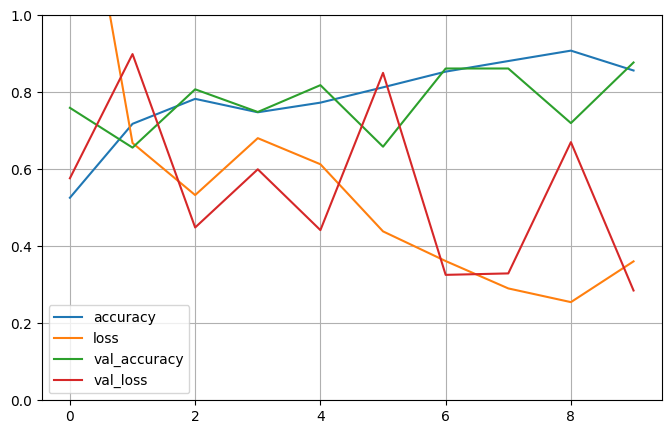

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# **Guardar el modelo en disco**

In [36]:
fcnn_model.save("modelo_fcnn_potato-disease.keras")

In [37]:
fcnn_model_disk = keras_core.models.load_model("modelo_fcnn_potato-disease.keras")

# **Predicción de nuevos ejemplos**

In [38]:
evaluation_result = fcnn_model_disk.evaluate(test_ds)

print(f"Test Loss: {evaluation_result[0]}")
print(f"Test Accuracy: {evaluation_result[1]}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8637 - loss: 0.3087
Test Loss: 0.33912473917007446
Test Accuracy: 0.8506944179534912


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


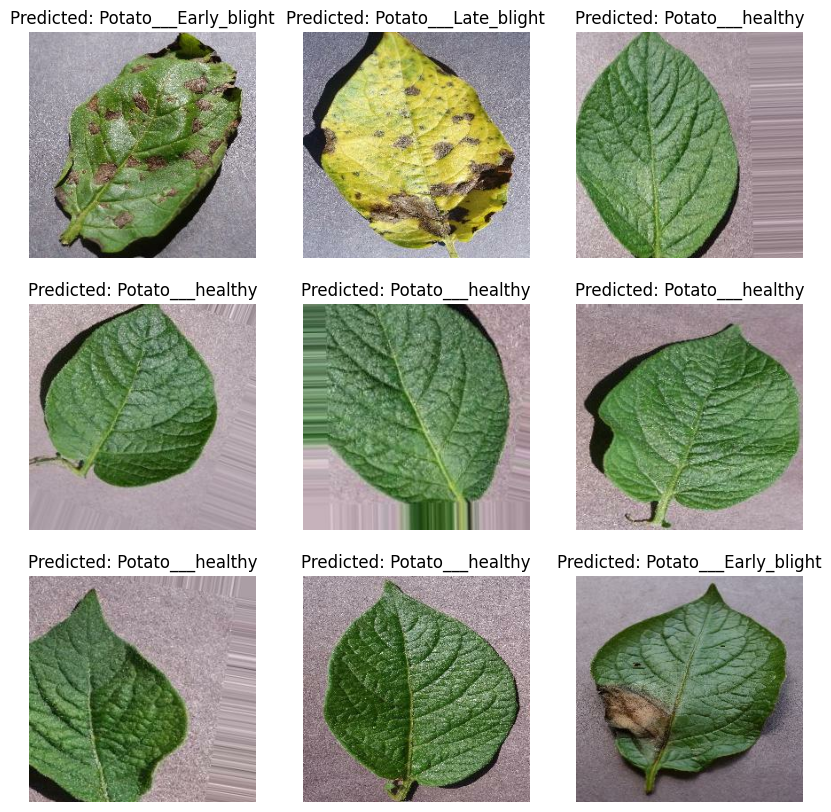

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predictions = fcnn_model_disk.predict(tf.expand_dims(images[i], axis=0))
    predicted_class = tf.argmax(predictions[0]).numpy()
    class_labels = ["Potato___Late_blight", "Potato___Early_blight", "Potato___healthy"]
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis("off")
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73m

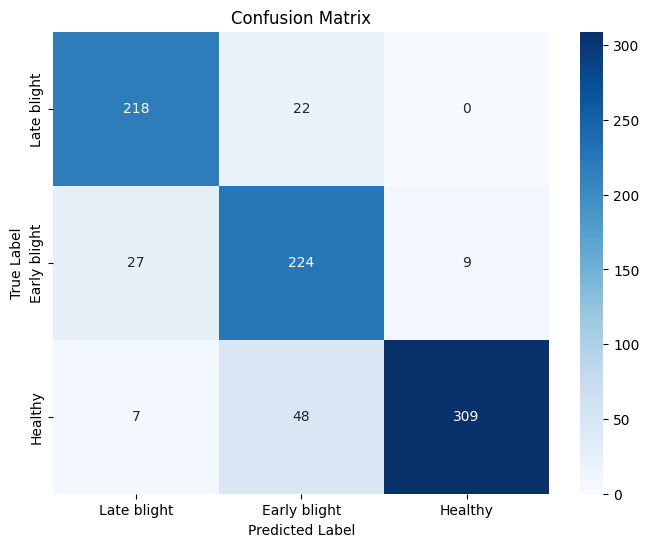

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Obtener las etiquetas verdaderas y las predicciones para el conjunto de prueba
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = fcnn_model_disk.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Late blight", "Early blight", "Healthy"], yticklabels=["Late blight", "Early blight", "Healthy"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [40]:
%%writefile app.py
import streamlit as st
import keras_core
import tensorflow as tf
from PIL import Image

Writing app.py


In [96]:
%%writefile app.py
import streamlit as st
import keras_core
import tensorflow as tf
from PIL import Image

# Cargar modelo guardado
model = keras_core.models.load_model("modelo_fcnn_potato-disease.keras")

class_labels = ["Potato___Late_blight", "Potato___Early_blight", "Potato___healthy"]

def preprocess_image(img):
    img = img.resize((256, 256))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

st.title("🧠 Clasificador de Hojas de Papa")
st.write("Sube una imagen para detectar si la hoja está sana o presenta una enfermedad.")

uploaded_file = st.file_uploader("Sube una imagen de hoja...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Imagen cargada", use_column_width=True)
    img_array = preprocess_image(image)
    predictions = model.predict(img_array)
    predicted_class = tf.argmax(predictions[0]).numpy()

    st.success(f"Resultado: {class_labels[predicted_class]}")
    st.write(f"Confianza: {predictions[0][predicted_class]*100:.2f}%")

Overwriting app.py


In [97]:
!pip install pyngrok --quiet

In [110]:
import subprocess
import time

# Ejecutar Streamlit como proceso background
process = subprocess.Popen(['streamlit', 'run', 'app.py', '--server.port=8501'])
time.sleep(5)  # Esperar a que levante el servidor

In [111]:
from pyngrok import ngrok
from google.colab import userdata
import os

os.environ['NGROK_AUTH_TOKEN'] = userdata.get('NGROK_AUTH_TOKEN')
public_url = ngrok.connect(addr="8501", proto="http")
print(f"Tu app está en: {public_url}")

Tu app está en: NgrokTunnel: "https://5e7d-35-203-157-251.ngrok-free.app" -> "http://localhost:8501"


In [41]:
from google.colab import files
import tensorflow as tf
import keras_core

uploaded = files.upload()

for fn in uploaded.keys():
  img = keras_core.utils.load_img(fn, target_size=(256, 256))
  img_array = keras_core.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = fcnn_model_disk.predict(img_array)
  predicted_class = tf.argmax(predictions[0]).numpy()
  class_labels = ["Potato___Late_blight", "Potato___Early_blight", "Potato___healthy"]
  plt.figure(figsize=(6, 6))
  plt.imshow(img)
  plt.title(f"Image {fn} predicted as: {class_labels[predicted_class]}")
  plt.axis('off')
  plt.show()

KeyboardInterrupt: 